In [3]:
import sys
import os

# Workaround to make packages work in both Jupyter notebook and Python
module_root_name = "AgeEstimator"
module_paths = [
    os.path.abspath(os.path.join('..')),
    os.path.abspath(os.path.join('../..')),
    os.path.abspath(os.path.join('../../..'))
]
module_paths = list(filter(lambda x: x.endswith(module_root_name), module_paths))
module_path = module_paths[0] if len(module_paths) == 1 else ""
if module_path not in sys.path:
    sys.path.append(module_path)

from server.data.dataset import DataLoader

dl = DataLoader()
x_train, y_train = dl.load_train()
x_test, y_test = dl.load_test()

In [2]:
import time
import pandas as pd
import numpy as np
from scipy.ndimage import filters
from pylab import *
from PIL import Image, ImageFilter 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# create csv files
df_train = pd.DataFrame(x_train, columns=['filename'])
df_train['age'] = pd.Series(y_train)
df_train.head()

,filename,age
0,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,17
1,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,39
2,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,26
3,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,29
4,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,42


In [4]:
df_test = pd.DataFrame(x_test, columns=['filename'])
df_test['age'] = pd.Series(y_test)
df_test.head()

,filename,age
0,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,26
1,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,29
2,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,38
3,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,30
4,/Users/xiaoxiao/Desktop/SCU/2020winter/coen281...,23


In [5]:
df_train.to_csv('training_set.csv', index=False)
df_test.to_csv('test_set.csv', index=False)

In [6]:
print(f'Number of training examples: {df_train.shape[0]}')
print(f'Number of test examples: {df_test.shape[0]}')

Number of training examples: 149724
Number of test examples: 37430


In [7]:
train_max = df_train.max()['age']
test_max = df_test.max()['age']
print(train_max, test_max)

116 110


In [8]:
num_ages = np.unique(df_train['age'].values).shape[0]
print(f'Number of age labels: {num_ages}')

Number of age labels: 102


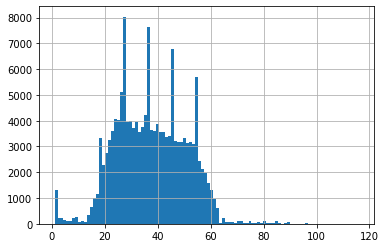

In [9]:
histogram = df_train['age'].hist(bins=df_train['age'].nunique())

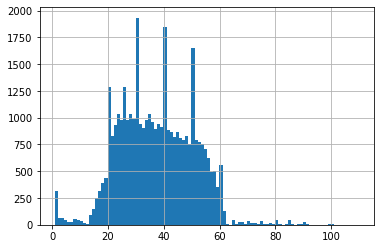

In [10]:
histogram = df_test['age'].hist(bins=df_test['age'].nunique())

In [11]:
class DatasetAge(Dataset):
    """Custom Dataset for loading images"""

    def __init__(self, csv_path, transform=None):

        df = pd.read_csv(csv_path)
        self.csv_path = csv_path
        self.df = df
        self.y = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.df.iloc[index]['filename']).convert('L')
        img = img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [12]:
TRAIN_CSV_PATH = 'training_set.csv'
TEST_CSV_PATH = 'test_set.csv'
BATCH_SIZE = 64

In [13]:
train_indices = torch.arange(0, df_train.shape[0]-1000).numpy()
valid_indices = torch.arange(df_train.shape[0]-1000, df_train.shape[0]).numpy()

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DatasetAge(csv_path=TRAIN_CSV_PATH, transform=transform)

valid_dataset = DatasetAge(csv_path=TRAIN_CSV_PATH, transform=transform)

test_dataset = DatasetAge(csv_path=TEST_CSV_PATH, transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)



In [4]:
from torch.autograd import Variable
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
epochs = 100
inputDim = 250*250
outputDim = 121
learningRate = 0.001 

model = LogisticRegression(inputDim, outputDim)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

In [23]:
def compute_mae_mse_acc(model, data_loader):
    mae, mse, acc, num_examples = 0., 0., 0, 0
    for i, (images, labels) in enumerate(data_loader):

        images = Variable(images.view(-1, inputDim))
        labels = Variable(labels)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        num_examples += labels.size(0)
        acc += torch.sum(predicted == labels)
        mae += torch.sum(torch.abs(predicted - labels))
        mse += torch.sum((predicted - labels)**2)
    acc = acc.float() / num_examples   
    mae = mae.float() / num_examples
    mse = mse.float() / num_examples
    return mae, mse, acc

In [24]:
start_time = time.time()

l = []
train_mae_list, valid_mae_list = [], []
train_mse_list, valid_mse_list = [], []
train_acc_list, valid_acc_list = [], []

for epoch in range(int(epochs)):
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, inputDim))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        l.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if (not (i+1) % 400) or (i+1 == len(train_loader)):
            print (f'Epoch: {epoch+1:03d}/{epochs:03d} | '
                   f'Batch {i+1:03d}/{len(train_loader):03d} |' 
                   f' Loss: {loss.item():.4f}')
    with torch.set_grad_enabled(False):
        
        train_mae, train_mse, train_acc = compute_mae_mse_acc(model, train_loader)
        valid_mae, valid_mse, valid_acc = compute_mae_mse_acc(model, valid_loader)
 
        print(f'Epoch: {epoch+1:03d}/{epochs:03d}\n'
              f'Train MAE: {train_mae:.2f} | Validation MAE: {valid_mae:.2f}')
        
        train_mae_list.append(train_mae)
        valid_mae_list.append(valid_mae)
        train_mse_list.append(train_mse)
        valid_mse_list.append(valid_mse)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/100 | Batch 400/2324 | Loss: 20.9186
Epoch: 001/100 | Batch 800/2324 | Loss: 14.0802
Epoch: 001/100 | Batch 1200/2324 | Loss: 13.5779
Epoch: 001/100 | Batch 1600/2324 | Loss: 22.2548
Epoch: 001/100 | Batch 2000/2324 | Loss: 25.1380
Epoch: 001/100 | Batch 2324/2324 | Loss: 16.8950
Epoch: 001/100
Train MAE: 12.33 | Validation MAE: 12.37
Time elapsed: 14.06 min
Epoch: 002/100 | Batch 400/2324 | Loss: 12.1389
Epoch: 002/100 | Batch 800/2324 | Loss: 12.8247
Epoch: 002/100 | Batch 1200/2324 | Loss: 10.7119
Epoch: 002/100 | Batch 1600/2324 | Loss: 17.5610
Epoch: 002/100 | Batch 2000/2324 | Loss: 13.6182
Epoch: 002/100 | Batch 2324/2324 | Loss: 14.2620
Epoch: 002/100
Train MAE: 13.16 | Validation MAE: 13.30
Time elapsed: 13.88 min
Epoch: 003/100 | Batch 400/2324 | Loss: 12.5524
Epoch: 003/100 | Batch 800/2324 | Loss: 19.9387
Epoch: 003/100 | Batch 1200/2324 | Loss: 15.6395
Epoch: 003/100 | Batch 1600/2324 | Loss: 19.3901
Epoch: 003/100 | Batch 2000/2324 | Loss: 17.5174
Epoch: 003/10

Epoch: 023/100 | Batch 800/2324 | Loss: 9.6691
Epoch: 023/100 | Batch 1200/2324 | Loss: 9.9456
Epoch: 023/100 | Batch 1600/2324 | Loss: 7.4722
Epoch: 023/100 | Batch 2000/2324 | Loss: 6.7588
Epoch: 023/100 | Batch 2324/2324 | Loss: 7.6405
Epoch: 023/100
Train MAE: 10.45 | Validation MAE: 12.95
Time elapsed: 13.11 min
Epoch: 024/100 | Batch 400/2324 | Loss: 7.3347
Epoch: 024/100 | Batch 800/2324 | Loss: 10.9734
Epoch: 024/100 | Batch 1200/2324 | Loss: 13.9965
Epoch: 024/100 | Batch 1600/2324 | Loss: 7.5572
Epoch: 024/100 | Batch 2000/2324 | Loss: 8.3124
Epoch: 024/100 | Batch 2324/2324 | Loss: 7.8691
Epoch: 024/100
Train MAE: 10.00 | Validation MAE: 11.98
Time elapsed: 13.26 min
Epoch: 025/100 | Batch 400/2324 | Loss: 16.0641
Epoch: 025/100 | Batch 800/2324 | Loss: 8.7437
Epoch: 025/100 | Batch 1200/2324 | Loss: 12.8265
Epoch: 025/100 | Batch 1600/2324 | Loss: 12.4726
Epoch: 025/100 | Batch 2000/2324 | Loss: 11.1537
Epoch: 025/100 | Batch 2324/2324 | Loss: 7.7401
Epoch: 025/100
Train MA

Epoch: 045/100 | Batch 2000/2324 | Loss: 10.3052
Epoch: 045/100 | Batch 2324/2324 | Loss: 6.8307
Epoch: 045/100
Train MAE: 8.03 | Validation MAE: 11.67
Time elapsed: 11.39 min
Epoch: 046/100 | Batch 400/2324 | Loss: 7.0504
Epoch: 046/100 | Batch 800/2324 | Loss: 5.7360
Epoch: 046/100 | Batch 1200/2324 | Loss: 15.3221
Epoch: 046/100 | Batch 1600/2324 | Loss: 9.7190
Epoch: 046/100 | Batch 2000/2324 | Loss: 6.9206
Epoch: 046/100 | Batch 2324/2324 | Loss: 12.0448
Epoch: 046/100
Train MAE: 8.47 | Validation MAE: 11.84
Time elapsed: 11.42 min
Epoch: 047/100 | Batch 400/2324 | Loss: 9.8999
Epoch: 047/100 | Batch 800/2324 | Loss: 6.0137
Epoch: 047/100 | Batch 1200/2324 | Loss: 5.8443
Epoch: 047/100 | Batch 1600/2324 | Loss: 10.1439
Epoch: 047/100 | Batch 2000/2324 | Loss: 5.6750
Epoch: 047/100 | Batch 2324/2324 | Loss: 10.3230
Epoch: 047/100
Train MAE: 8.70 | Validation MAE: 13.07
Time elapsed: 11.44 min
Epoch: 048/100 | Batch 400/2324 | Loss: 6.8086
Epoch: 048/100 | Batch 800/2324 | Loss: 6.0

Epoch: 068/100 | Batch 400/2324 | Loss: 14.8769
Epoch: 068/100 | Batch 800/2324 | Loss: 4.8805
Epoch: 068/100 | Batch 1200/2324 | Loss: 9.9033
Epoch: 068/100 | Batch 1600/2324 | Loss: 5.6765
Epoch: 068/100 | Batch 2000/2324 | Loss: 13.6181
Epoch: 068/100 | Batch 2324/2324 | Loss: 11.2580
Epoch: 068/100
Train MAE: 8.78 | Validation MAE: 13.30
Time elapsed: 11.17 min
Epoch: 069/100 | Batch 400/2324 | Loss: 5.2833
Epoch: 069/100 | Batch 800/2324 | Loss: 7.1050
Epoch: 069/100 | Batch 1200/2324 | Loss: 10.0690
Epoch: 069/100 | Batch 1600/2324 | Loss: 7.1880
Epoch: 069/100 | Batch 2000/2324 | Loss: 6.5123
Epoch: 069/100 | Batch 2324/2324 | Loss: 8.3595
Epoch: 069/100
Train MAE: 7.80 | Validation MAE: 12.02
Time elapsed: 11.14 min
Epoch: 070/100 | Batch 400/2324 | Loss: 6.8935
Epoch: 070/100 | Batch 800/2324 | Loss: 6.4129
Epoch: 070/100 | Batch 1200/2324 | Loss: 5.7390
Epoch: 070/100 | Batch 1600/2324 | Loss: 7.7507
Epoch: 070/100 | Batch 2000/2324 | Loss: 4.2910
Epoch: 070/100 | Batch 2324/

Epoch: 090/100 | Batch 2000/2324 | Loss: 6.2745
Epoch: 090/100 | Batch 2324/2324 | Loss: 6.4223
Epoch: 090/100
Train MAE: 5.71 | Validation MAE: 12.01
Time elapsed: 11.21 min
Epoch: 091/100 | Batch 400/2324 | Loss: 6.4996
Epoch: 091/100 | Batch 800/2324 | Loss: 6.8287
Epoch: 091/100 | Batch 1200/2324 | Loss: 5.5672
Epoch: 091/100 | Batch 1600/2324 | Loss: 7.2925
Epoch: 091/100 | Batch 2000/2324 | Loss: 5.9996
Epoch: 091/100 | Batch 2324/2324 | Loss: 11.7878
Epoch: 091/100
Train MAE: 5.89 | Validation MAE: 10.97
Time elapsed: 11.26 min
Epoch: 092/100 | Batch 400/2324 | Loss: 9.2565
Epoch: 092/100 | Batch 800/2324 | Loss: 4.9558
Epoch: 092/100 | Batch 1200/2324 | Loss: 5.5935
Epoch: 092/100 | Batch 1600/2324 | Loss: 3.7780
Epoch: 092/100 | Batch 2000/2324 | Loss: 5.3744
Epoch: 092/100 | Batch 2324/2324 | Loss: 8.5201
Epoch: 092/100
Train MAE: 6.48 | Validation MAE: 11.88
Time elapsed: 11.27 min
Epoch: 093/100 | Batch 400/2324 | Loss: 3.2080
Epoch: 093/100 | Batch 800/2324 | Loss: 6.1006


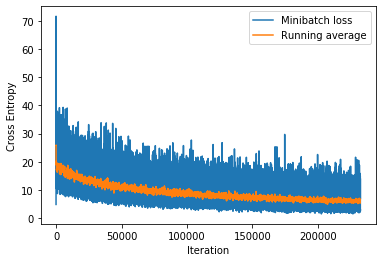

In [36]:
plt.plot(l, label='Minibatch loss')
plt.plot(np.convolve(l, np.ones(200,)/200, mode='valid'), label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

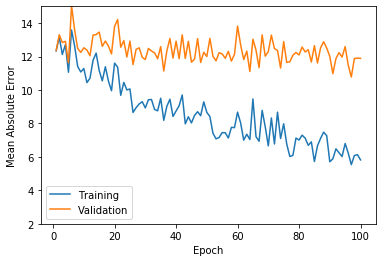

In [27]:
plt.plot(np.arange(1, epochs+1), train_mae_list, label='Training')
plt.plot(np.arange(1, epochs+1), valid_mae_list, label='Validation')
plt.ylim(2, 15)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

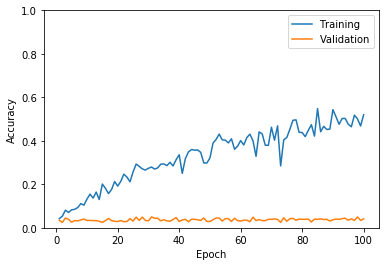

In [29]:
plt.plot(np.arange(1, epochs+1), train_acc_list, label='Training')
plt.plot(np.arange(1, epochs+1), valid_acc_list, label='Validation')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
with torch.set_grad_enabled(False):
    test_mae, test_mse, test_acc = compute_mae_mse_acc(model=model, data_loader=test_loader)
    
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Test ACC: {test_acc*100:.2f}%')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120bfb840>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120bfb840>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120bfb840>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120bfb840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/site-packages/tor

Test MAE: 12.26
Test MSE: 246.34
Test ACC: 3.39%


In [31]:
torch.save(model.state_dict(), 'param2')

In [8]:
model2 = LogisticRegression(inputDim, outputDim)
model2.load_state_dict(torch.load('param'))
model2.eval()

LogisticRegression(
  (linear): Linear(in_features=62500, out_features=121, bias=True)
)

In [35]:
with torch.set_grad_enabled(False):
    test_mae, test_mse, test_acc = compute_mae_mse_acc(model=model2, data_loader=test_loader)
    
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Test ACC: {test_acc*100:.2f}%')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120bfb840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120bfb840>
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
Traceback (most recent call last):
    w.join()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_worker

Test MAE: 10.83
Test MSE: 211.68
Test ACC: 4.67%
